# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

In [23]:
import numpy as np

a = np.random.choice(60000, (2, 60000))
a = a[:, a[0]!=a[1]]
a.shape

(2, 59999)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC(kernel='linear', probability=True)
        else:
            raise ValueError('YOU FUCKING IDIOT')
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.scaler = StandardScaler()
        X_new = X.copy()
        X_new = self.scaler.fit_transform(X_new)
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X_new = self.pca.fit_transform(X_new)
        ind = np.random.choice(X_new.shape[0], size=(2, 1000))
        ind = ind[:, ind[0] != ind[1]]
        self.sigma = np.median(np.sum((X_new[ind[0]] - X_new[ind[1]]) **2 , axis=1)) ** 0.5
        self.w = np.random.normal(0, 1 / self.sigma, size=(X_new.shape[1], self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        
        X_new = np.cos(X_new @ self.w + self.b)
        
        self.model.fit(X_new, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)

        X_new = np.cos(X_new @ self.w + self.b)
        return self.model.predict_proba(X_new)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)

        X_new = np.cos(X_new @ self.w + self.b)
        return self.model.predict(X_new)

In [65]:
pipeline = RFFPipeline(classifier='logreg')
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy_score(y_test, y_pred)

0.8565

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

RFF SVM

In [29]:
pipeline = RFFPipeline(classifier='svm')
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy_score(y_test, y_pred)

0.8772

SVD with linear kernel

In [30]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(x_train)
X_test_scal = scaler.transform(x_test)

lin_svm = SVC(kernel='linear').fit(X_train_scal, y_train)
y_pred = lin_svm.predict(X_test_scal)
accuracy_score(y_test, y_pred)

0.837

RBF SVM

In [39]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(x_train)
X_test_scal = scaler.transform(x_test)

lin_svm = SVC().fit(X_train_scal, y_train)
y_pred = lin_svm.predict(X_test_scal)
accuracy_score(y_test, y_pred)

0.8836

Сatboost

In [ ]:
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import train_test_split


x_train_tr, x_val, y_train_tr, y_val = train_test_split(x_train, y_train, test_size=0.1)

scaler = StandardScaler()
X_train_scal = scaler.fit_transform(x_train_tr)
X_val_scal = scaler.transform(x_val)
X_test_scal = scaler.transform(x_test)

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scal)
X_val_pca = pca.transform(X_val_scal)
X_test_pca = pca.transform(X_test_scal)


def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }

    boosting = CatBoostClassifier(**params, verbose=0)
    boosting.fit(X_train_pca, y_train_tr)
    return boosting.score(X_val_pca, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [38]:
boosting = CatBoostClassifier(**study.best_params, verbose=0).fit(X_train_pca, y_train_tr)
y_pred = boosting.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.8459

Картина следующая: 
1. лучшее качетсво у rbf(оно гауссовское ядро), из svm он отработал быстрее всех
2. rff svm работал гораздо дольше, но в плане качество сравнимо с rbf
3. svm с линейным ядром показал себя хуже всех(в целом ожидаемо)
4. бустинг выдал качество не очень, но учился быстро(даже с учётом подбора гиперпараметров)

Подытоживая, можно сказать, что идея с rff работает, но долго, и есть rdf, который и быстрее, и лучше.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [42]:
#1)
results = {}
pipeline = RFFPipeline(use_PCA=False)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
results['w/o pca'] = accuracy_score(y_test, y_pred)

for num_feat in [10, 50, 100, 150, 300]:
    pipeline = RFFPipeline(new_dim=num_feat)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    results[num_feat] = accuracy_score(y_test, y_pred)

(0.78, 0.90825)

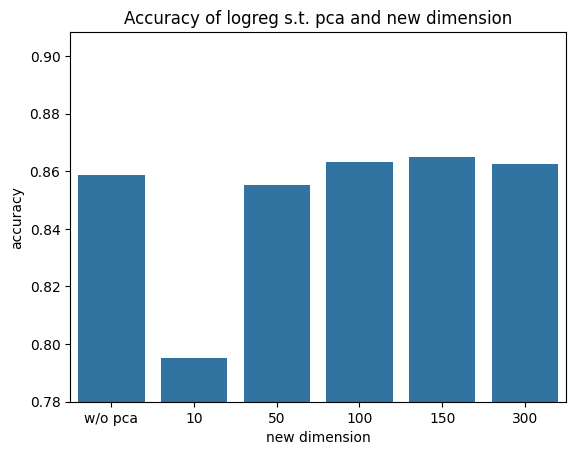

In [49]:
import seaborn as sns

ax = sns.barplot(results)
ax.set_title('Accuracy of logreg s.t. pca and new dimension')
ax.set_ylabel('accuracy')
ax.set_xlabel('new dimension')
ax.set_ylim(0.78)

In [53]:
#2)

results = {}
n_features = list(range(500, 5000, 500))

for n_feature in n_features:
    pipeline = RFFPipeline(n_features=n_feature)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    results[n_feature] = accuracy_score(y_test, y_pred)

(0.82, 0.901845)

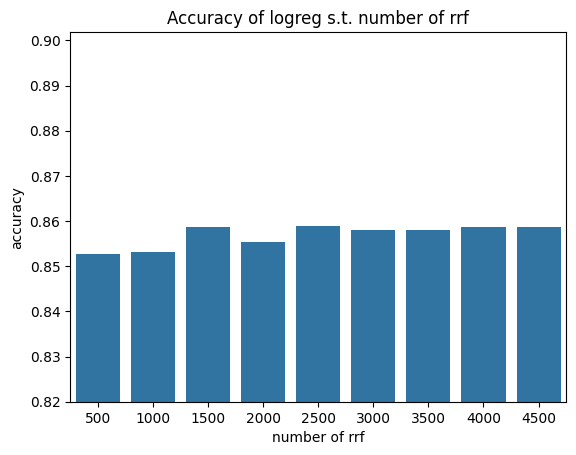

In [55]:
ax = sns.barplot(results)
ax.set_title('Accuracy of logreg s.t. number of rrf')
ax.set_ylabel('accuracy')
ax.set_xlabel('number of rrf')
ax.set_ylim(0.82)

__Выводы__:
1. Видим, что сжатие чуть улучшает акураси, но главное не сжимать слишком сильно. В нашем случае сжатие в 5 раз является оптимальным.
2. Увеличение количества признаков почти никак не меняет качество.
3. Тут даже не хочется запускать ничего. Если хочется получить лучше качество и есть готовность ждать(причём ждать не только обучения, но и предикта), то берём svm. Иначе берём ультразвуковой логрег и теряем немного в качестве. 

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [87]:
class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC(kernel='linear', probability=True)
        else:
            raise ValueError('YOU FUCKING IDIOT')
        if self.use_PCA:
            if self.n_features > self.new_dim and self.n_features % self.new_dim:
                raise ValueError('YOU FUCKING IDIOT')
            
    def _compute_w(self, d):
        g = np.random.normal(size=(d, d))
        q, _ = np.linalg.qr(g)
        s = np.sqrt(np.random.chisquare(d, d))

        return 1 / self.sigma * (q @ np.diag(s))

        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.scaler = StandardScaler()
        X_new = X.copy()
        X_new = self.scaler.fit_transform(X_new)
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X_new = self.pca.fit_transform(X_new)

        ind = np.random.choice(X_new.shape[0], size=(2, 1000))
        ind = ind[:, ind[0] != ind[1]]
        self.sigma = np.median(np.sum((X_new[ind[0]] - X_new[ind[1]]) **2 , axis=1)) ** 0.5


        if self.n_features > self.new_dim and self.n_features % X_new.shape[1]:
            raise ValueError('YOU FUCKING IDIOT')

        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        if self.n_features <= X_new.shape[1]:
            self.w = self._compute_w(X_new.shape[1])[:, :self.n_features]
        else:
            ws = []
            for _ in range(self.n_features // X_new.shape[1]):
                ws.append(self._compute_w(X_new.shape[1]))
            self.w = np.hstack(ws)
        
        X_new = np.cos(X_new @ self.w + self.b)
        
        self.model.fit(X_new, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)

        X_new = np.cos(X_new @ self.w + self.b)
        self.model.p
        return self.model.predict_proba(X_new)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)

        X_new = np.cos(X_new @ self.w + self.b)
        return self.model.predict(X_new)

In [89]:
pipeline = ORFPipeline()
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy_score(y_test, y_pred)

0.8549

In [90]:
pipeline = ORFPipeline(classifier='svm')
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy_score(y_test, y_pred)

0.8807

По качеству примерно то же самое. По времени тоже.

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [138]:
from scipy.special import expit
def new_features(X, n_features, d, sigma, mode, params=None):
    if mode == 0:
        if params is None:
            w = np.random.normal(0, 1 / sigma, size=(d, n_features))
            b = np.random.uniform(-np.pi, np.pi, n_features)
        else:
            w, b = params[0], params[1]
        return np.cos(X @ w + b), (w, b)
    elif mode == 1:
        if params is None:
            w = np.random.normal(0, 1 / sigma, size=(d, n_features))
            b = np.random.uniform(-np.pi, np.pi, n_features)
        else:
            w, b = params[0], params[1]
        return np.sin(X @ w + b), (w, b)
    elif mode == 2:
        if params is None:
            w = np.random.normal(0, 1 / sigma, size=(d, n_features))
        else:
            w = params
        return np.sign(X @ w), w
    elif mode == 3:
        if params is None:
            w = np.random.normal(0, 1 / sigma, size=(d, n_features))
            b = np.random.normal(size = n_features)
        else:
            w, b = params[0], params[1]
        return np.sign(X @ w + b), (w, b)
    elif mode == 4: #лог-мономы
        Deg = 0
        sgn = 0
        if params is None:
            Deg = np.random.randint(0, 10, size=(d, n_features))
            sgn = np.random.choice([-1, 1], size=n_features)
        else:
            Deg, sgn = params[0], params[1]
        return (np.log(np.abs(X)) @ Deg) * sgn, (Deg, sgn)
    elif mode == 5: #лог-мономы со сдвигами
        b = 0
        Deg = 0
        sgn = 0
        if params is None:
            b = np.random.normal(scale = sigma, size = d)
            Deg = np.random.randint(0, 3, size=(d, n_features))
            sgn = np.random.choice([-1, 1], size=n_features)
        else:
            b, Deg, sgn = params[0], params[1], params[2]
        return (np.log(np.abs(X + b)) @ Deg) * sgn, (b, Deg, sgn)
    elif mode == 6:
        if params is None:
            w = np.random.normal(0, 1 / sigma, size=(d, n_features))
            b = np.random.uniform(-np.pi, np.pi, n_features)
        else:
            w, b = params[0], params[1]
        return np.tanh(X @ w + b), (w, b)
    elif mode == 7:
        if params is None:
            w = np.random.normal(0, 1 / sigma, size=(d, n_features))
            b = np.random.uniform(-np.pi, np.pi, n_features)
        else:
            w, b = params[0], params[1]
        return expit(X @ w + b), (w, b)

In [139]:
class DiffFeaturesPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', mode=0):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.mode = mode
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC(kernel='linear', probability=True)
        else:
            raise ValueError('YOU FUCKING IDIOT')
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.scaler = StandardScaler()
        X_new = X.copy()
        X_new = self.scaler.fit_transform(X_new)
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X_new = self.pca.fit_transform(X_new)
        ind = np.random.choice(X_new.shape[0], size=(2, 1000))
        ind = ind[:, ind[0] != ind[1]]
        self.sigma = np.median(np.sum((X_new[ind[0]] - X_new[ind[1]]) **2 , axis=1)) ** 0.5

        X_new, self.params = new_features(X_new, self.n_features, X_new.shape[1], self.sigma, self.mode)
        
        self.model.fit(X_new, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)

        X_new, _ = new_features(X_new, self.n_features, X_new.shape[1], self.sigma, self.mode, self.params)
        return self.model.predict_proba(X_new)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)
        X_new, _ = new_features(X_new, self.n_features, X_new.shape[1], self.sigma, self.mode, self.params)
        return self.model.predict(X_new)

In [140]:
for i in range(8):
    pipeline = DiffFeaturesPipeline(mode=i)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    print(accuracy_score(y_test, y_pred))

0.8568
0.8587
0.8348
0.8424
0.6149
0.6976
0.835
0.8082


__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [195]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, K: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return 0.5 * np.linalg.norm(K @ self.w - y) ** 2 + self.regularization / 2 * self.w.T @ K @ self.w

    def calc_grad(self, K: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return K @ (K @ self.w - y) + self.regularization * K @ self.w

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        self.x = x.copy()
        K = self.kernel(x)
        if self.w is None:
            self.w = np.zeros(x.shape[0])
        self.loss_history.append(self.calc_loss(K, y))
        for _ in range(self.max_iter):
            diff = self.lr * self.calc_grad(K, y)
            self.w -= diff
            self.loss_history.append(self.calc_loss(K, y))
            if np.isnan(diff).any() or np.linalg.norm(diff) ** 2 < self.tolerance:
                break
        return self
        

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        K = self.kernel(x, self.x)
        return K @ self.w

In [141]:
from sklearn.linear_model import Ridge
class DiffFeaturesPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', mode=0):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.mode = mode
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC(kernel='linear', probability=True)
        elif self.classifier == 'linreg':
            self.model = Ridge()
        else:
            raise ValueError('YOU FUCKING IDIOT')
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.scaler = StandardScaler()
        X_new = X.copy()
        X_new = self.scaler.fit_transform(X_new)
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X_new = self.pca.fit_transform(X_new)
        ind = np.random.choice(X_new.shape[0], size=(2, 1000))
        ind = ind[:, ind[0] != ind[1]]
        self.sigma = np.median(np.sum((X_new[ind[0]] - X_new[ind[1]]) **2 , axis=1)) ** 0.5

        X_new, self.params = new_features(X_new, self.n_features, X_new.shape[1], self.sigma, self.mode)
        
        self.model.fit(X_new, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.classifier == 'linreg':
            raise ValueError('YOU FUCKING IDIOT')
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)

        X_new, _ = new_features(X_new, self.n_features, X_new.shape[1], self.sigma, self.mode, self.params)
        return self.model.predict_proba(X_new)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_new = X.copy()
        X_new = self.scaler.transform(X_new)
        if self.use_PCA:
            X_new = self.pca.transform(X_new)
        X_new, _ = new_features(X_new, self.n_features, X_new.shape[1], self.sigma, self.mode, self.params)
        return self.model.predict(X_new)

In [191]:
X = np.random.rand(10000, 500)
w = np.random.rand(X.shape[1])
y = X @ w + np.random.randn(X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [196]:
from sklearn.metrics import mean_squared_error as mse
kernel_linreg = KernelRidgeRegression().fit(X_train, y_train)
y_pred = kernel_linreg.predict(X_test)
mse(y_test, y_pred)

14888.876008987554

In [176]:
rff_linreg = DiffFeaturesPipeline(classifier='linreg').fit(X_train, y_train)
y_pred = rff_linreg.predict(X_test)
mse(y_test, y_pred)

15.036631026467203